보안유지 ( api_key는 유출상, github 올리지 말기)

In [19]:
# chatbot
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage

# llm
from langchain import PromptTemplate, LLMChain
from langchain.llms import OpenAI

import os
import gradio as gr
import os
from playsound import playsound
import openai
from openai import OpenAI
import playsound
import speech_recognition as sr
import pandas as pd
import nltk
import konlpy
from nltk import word_tokenize
from konlpy.tag import Okt
from wordcloud import WordCloud
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
# from pykospacing import Spacing
import seaborn as sns
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

api_key = "본인의 키"

openai.api_key = api_key
client = OpenAI

data = pd.read_csv("./data.csv")
data.loc[3] = ["김태현", 1,'가정형편, 주거관련 위기']


In [20]:
data

,이름,주민등록상,문제
0,김태경,혼자,건강보험료 연체
1,주예서,혼자,건강 문제
2,강민지,2,공과급 체납
3,김태현,1,"가정형편, 주거관련 위기"


In [28]:
# 이걸 입력받을 수 있게 하면 좋을것 같음 !!
data = pd.read_csv("./data.csv")
data.loc[3] = ["김태현", 1,'가정형편, 주거관련 위기']


a=0

t= Okt()

# 음성인식 모듈
def recognize_speech(timeout=60):
    recognizer = sr.Recognizer()
    microphone = sr.Microphone()

    with microphone as source:
        recognizer.adjust_for_ambient_noise(source) 
        print("음성 인식 대기중")
        audio = recognizer.listen(source,timeout=timeout)

    try:
        text = recognizer.recognize_google(audio, language = "ko")
        print(text)
        return text 
    except sr.UnknownValueError:
        print("인식할 수 없습니다.")
    except sr.RequestError as e:
        print("인식에 문제가 있습니다.", e)


# tts 모듈
def tts_module(texts):
    voices = ['nova']
    for i, text in enumerate(texts):
        speech_file_path = f'text_{i}.mp3'
        response = openai.audio.speech.create(
            model="tts-1",
            voice=voices[i],
            input=" "+text
        )
        response.stream_to_file(speech_file_path)
        playsound.playsound(f"./text_{i}.mp3", block=True)
        os.remove(f'./text_{i}.mp3')


def generate_wordcloud(word_counts, font_path, max_font_size=100, width=800, height=400, background_color='white', max_words=50):
    wordcloud = WordCloud(
        font_path=font_path,
        max_font_size=max_font_size,
        width=width,
        height=height,
        background_color=background_color,
        max_words=max_words
    )
    
    wordcloud.generate_from_frequencies(word_counts)
    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()
    

def word_graph_and_wordcloud(tokens_const, max_words=10):
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

    # 사용할 폰트 경로 설정
    font_path = "c:/Windows/Fonts/malgun.ttf"

    # 토큰 빈도수 계산
    const_cnt = {}
    for word in tokens_const:
        const_cnt[word] = const_cnt.get(word, 0) + 1

    # Word Cloud 생성 및 표시
    generate_wordcloud(const_cnt, font_path)

    # 막대 그래프 표시
    sorted_w = sorted(const_cnt.items(), key=lambda kv: kv[1])
    print(sorted_w[-max_words:])
    n, w = zip(*sorted_w[-max_words:])
    
    plt.barh(range(len(n)), w, tick_label=n)
    plt.show()
    

# 텍스트 생성 모듈
chat_ai = ChatOpenAI(openai_api_key=api_key, temperature=0.5, model="gpt-4-1106-preview")

chat_template = f"""필수 : 나는 복지상담을 진행하는 음성봇 이다.
전화통화를 하는 것처럼 대화를 해야한다. 
한번에 한가지 질문만 한다. 
공손하고 예의바르게 말을 해야한다. 
답변은 2줄이내로 진행한다. 
해당 전화는 본 챗봇이 먼저 전화를 건 상황이다.
총 6번이상의 대화가 오고가도록 한다.
음성 봇이라고 자기소개는 하지 않는다

0. 상대방의 이름은 {data["이름"][a]}이다. 해당 이름으로 대화를 한다.

1. 상대방의 문제 상황은 "{data["문제"][a]}" 이다. 보건복지부 자료에 따라 연락했다고 말하며 해당 문제 상황에 있는게 맞는지 사실여부를 확인한다.

2. 사실이 아니라는 의미의 대답을 하면 상담이 필요 없는지 묻는다.

3. 상담이 필요 없다고 대답하면 친절한 어투로 대화를 종료한다.

4. 사실이 맞다면 {data["문제"][a]}에 대해 구체적으로 질문한다.

5. {data["문제"][a]}에 대해 구체적인 상황은 어떠한지 질문을 한다.

6. 상대방과 대화도중 새로운 문제나 상황이 발생했으면 그 문제,상황에 대해서 다시 구체적으로 질문한다.

7. 상대방의 문제에 대해 어느정도 질문을 했으면 주변에 도움을 요청할만한 보호자가 없는지 물어본다.

8. 질문이 최소 5번 이상 오가고 난 이후에, 상대방의 어려움에 관련된 복지 서비스를 추천해준다.

9. 서비스를 모두 추천해준 후 추가 상담을 원하는지 물어본다.

10. 추가 상담을 원하면, 대면 상담을 진행할지 비대면 상담을 진행할지 묻고, 추가 상담을 원하지 않는다면 친절한 어투로 대화를 종료한다.

"""

# 상담 종료 후 시각화 모듈 및 report 부분
def generate_wordcloud(word_counts, font_path, max_font_size=100, width=800, height=400, background_color='white', max_words=50):
    wordcloud = WordCloud(
        font_path=font_path,
        max_font_size=max_font_size,
        width=width,
        height=height,
        background_color=background_color,
        max_words=max_words
    )

    wordcloud.generate_from_frequencies(word_counts)

    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

def word_graph_and_wordcloud(tokens_const, max_words=5):
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    font_path = "c:/Windows/Fonts/malgun.ttf"
    
    # 토큰 빈도수 계산
    const_cnt = {}
    for word in tokens_const:
        const_cnt[word] = const_cnt.get(word, 0) + 1

    # Word Cloud 생성 및 표시
    generate_wordcloud(const_cnt, font_path)

    # 막대 그래프 표시
    sorted_w = sorted(const_cnt.items(), key=lambda kv: kv[1])
    print(sorted_w[-max_words:])
    n, w = zip(*sorted_w[-max_words:])
    
    plt.barh(range(len(n)), w, tick_label=n)
    plt.show()
    

def visualize_weighted_count(counts, category_names):
    data = pd.DataFrame({
        'Category': category_names,
        'Count' : counts
    #     'Weighted Count': [count * weight for count, weight in zip(counts, weights)]
    })
    data['Rank'] = data['Count'].rank(ascending=False, method='dense').astype(int)
    palette = sns.color_palette("viridis", n_colors=len(data))

    # 그래프 그리기
    plt.figure(figsize=(7, 10))
    plt.subplot(2,1,1)
    sns.barplot(x='Category', y = 'Count', data=data, palette='rocket')
    plt.xticks(fontsize=7)
    plt.title('욕구 카테고리 분류')
    
    plt.subplot(2,1,2)
    pie_chart = data['Count'].plot.pie(autopct=lambda p: f'{p:.1f}%' if p > 0 else '', labels=data['Category'])

# 각 섹션에 해당하는 카테고리 이름을 레이블로 추가
    for count, label in zip(data['Count'], data['Category']):
      pie_chart.text(0, 0, f'{count}:\n{label}', fontsize=10)
    plt.title('욕구 카테고리 분류')
    plt.show()

    

def categorize_desire():
    list_1 =['생활비','생활','형편','통장','빌리다','모으다','지출','월세','코로나','월급','수입','직장',
                '일자리','회사','근무','일용직','아르바이트','대리운전','그만두다','퇴사','잔고','퇴직금','재취업',
                '이력서','노력','포기','취업','취직','도움','힘들다','어려운','버티다','부담','어렵다','청하다',
                '실업','퇴직','실업급여','일용직','사장님','잘리다','직장','일']
    
    list_2 = ['병원','치료','수술','진단','검사','진료','입원','응급실','복용','처방','수면제','정신과','백신',
                '진통제','항암','약물','물리치료','아픈','심한','통증','증상','질병','골절','후유증','마비','병원비','비용','의료비','치료비','수술비',
                '비급여','약값','입원비','가병비','허리디스크','다리','머리','어깨','무릎','발목','손목','목디스크',
                '정형외과','당뇨','고혈압','뇌출혈','뇌경색','조현병','혈압','심장','두통','신장','유방암','교통사고','사고', '방치','산재','다치다','쓰러지다','넘어지다','일상생활','움직이다','재활','재발','요양병원','간병',
                '대학병원','보호자','중환자실','요양원','간병인','보건소','산정특례']
    
    list_3 = ['실무자','구청','직원','관할','심사','행정복지센터','안내','통보','온라인','내용',
                '이해','설명','전달','기다리다','답변','서류','제출','접수','신청','진단서','발급','문자','카톡']
    
    list_4 = ['아이','이혼','한부모','가정','딸아이','큰아이','아이아빠','애아빠','이혼후','키우다','양육','맡기다',
                '같이 살다','양육비','학원비','학비','학교','대학','학원','수업','재학중','초등학교','중학교','고등학교',
                '대학생','졸업','독립','입학','학업','진학','자취','공부','기숙사','힉생']
    
    list_5 = ['우울','우울증','공황장애','불안장애','스트레스','대인기피증','불면증','불안정','자살시도','극단적',
                '긴급지원','상담','의지','용기','혼자','정신과','답답하다','피하다','떠나다','미루다','무너지다','무섭다',
                '두렵다','괴롭다','자해','자살']
    
    list_6 = ['스마트폰','공과금','관리비','전기','건강보험료','가스비','세금','임대료','도시가스','의료보험','보험료',
                '통신비','교통비','집세','수도세','연체','체납','요금','끊기다','정지','중단','압류','밀리다',
                '단전','단수','단가스','전기료','국민연금','주거관리비']
    
    list_7 = ['대출금','대출이자','전세대출','신용대출','담보','담보대출','보증','신용카드','부채','높은',
                '채무','상환','카드값','쌓이다','개인회생','신용불량','신용불량자','신용','신용회복위원회','막히다',
                '카드론','입금','계좌','은행','금융권','사업실패','파산','벅찬','허덕이다','신용불량']
    
    list_8 = ['반지하','주거','아파트','전세','월세집','임대주택','임대아파트','전세임대','당첨','청약','선정','생활지원',
                '계약','집주인','재계약','만기','만료','부동산','입주','경매','전세사기','보증금','이사비용','이사']
    
    list_9 = ['거주','오래','주택','환경','주거환경','임대','건물','공사','수리','교체','치아','노후','임플란트','보일러',
                '바닥','장판','화장실','음식','관리','여름','곰팡이','심각한','기초','독거노인','노인','고령','제공','거부']
    list_10 = ['교육비','교육','급여','소득','재산','혜택','복지혜택','기준','조건']

    category_lists = [list_1, list_2, list_3, list_4, list_5, list_6,list_7,list_8,list_9,list_10]
    category_names = ["생계의 어려움(일자리)", "의료/건강", "문의", "양육", "정신 건강", "요금 체납", "대출 및 신용","주거","독거(노인)","교육비"]
    
    
    counts = [sum(1 for token in tokens_const if token in category_list) for category_list in category_lists]

    # 결과 시각화
    visualize_weighted_count(counts, category_names)


In [24]:

list_1 =['생활비','생활','형편','통장','빌리다','모으다','지출','월세','코로나','월급','수입','직장',
            '일자리','회사','근무','일용직','아르바이트','대리운전','그만두다','퇴사','잔고','퇴직금','재취업',
            '이력서','노력','포기','취업','취직','도움','힘들다','어려운','버티다','부담','어렵다','청하다',
            '실업','퇴직','실업급여','일용직','사장님','잘리다','직장','일']

list_2 = ['병원','치료','수술','진단','검사','진료','입원','응급실','복용','처방','수면제','정신과','백신',
            '진통제','항암','약물','물리치료','아픈','심한','통증','증상','질병','골절','후유증','마비','병원비','비용','의료비','치료비','수술비',
            '비급여','약값','입원비','가병비','허리디스크','다리','머리','어깨','무릎','발목','손목','목디스크',
            '정형외과','당뇨','고혈압','뇌출혈','뇌경색','조현병','혈압','심장','두통','신장','유방암','교통사고','사고', '방치','산재','다치다','쓰러지다','넘어지다','일상생활','움직이다','재활','재발','요양병원','간병',
            '대학병원','보호자','중환자실','요양원','간병인','보건소','산정특례']

list_3 = ['실무자','구청','직원','관할','심사','행정복지센터','안내','통보','온라인','내용',
            '이해','설명','전달','기다리다','답변','서류','제출','접수','신청','진단서','발급','문자','카톡']

list_4 = ['아이','이혼','한부모','가정','딸아이','큰아이','아이아빠','애아빠','이혼후','키우다','양육','맡기다',
            '같이 살다','양육비','학원비','학비','학교','대학','학원','수업','재학중','초등학교','중학교','고등학교',
            '대학생','졸업','독립','입학','학업','진학','자취','공부','기숙사','힉생']

list_5 = ['우울','우울증','공황장애','불안장애','스트레스','대인기피증','불면증','불안정','자살시도','극단적',
            '긴급지원','상담','의지','용기','혼자','정신과','답답하다','피하다','떠나다','미루다','무너지다','무섭다',
            '두렵다','괴롭다','자해','자살']

list_6 = ['스마트폰','공과금','관리비','전기','건강보험료','가스비','세금','임대료','도시가스','의료보험','보험료',
            '통신비','교통비','집세','수도세','연체','체납','요금','끊기다','정지','중단','압류','밀리다',
            '단전','단수','단가스','전기료','국민연금','주거관리비']

list_7 = ['대출금','대출이자','전세대출','신용대출','담보','담보대출','보증','신용카드','부채','높은',
            '채무','상환','카드값','쌓이다','개인회생','신용불량','신용불량자','신용','신용회복위원회','막히다',
            '카드론','입금','계좌','은행','금융권','사업실패','파산','벅찬','허덕이다','신용불량']

list_8 = ['반지하','주거','아파트','전세','월세집','임대주택','임대아파트','전세임대','당첨','청약','선정','생활지원',
            '계약','집주인','재계약','만기','만료','부동산','입주','경매','전세사기','보증금','이사비용','이사']

list_9 = ['거주','오래','주택','환경','주거환경','임대','건물','공사','수리','교체','치아','노후','임플란트','보일러',
            '바닥','장판','화장실','음식','관리','여름','곰팡이','심각한','기초','독거노인','노인','고령','제공','거부']
list_10 = ['교육비','교육','급여','소득','재산','혜택','복지혜택','기준','조건']

네 안녕하세요. 맞춤형 복지 음성 서비스 아이 입니다. 통화에 앞서 본 통화는 녹취된다는 사실 말씀드립니다
User:  네 안녕하세요
AI: 안녕하세요, 김태경 님. 보건복지부 자료에 따라 연락드린 건데, 혹시 건강보험료 연체 문제로 어려움을 겪고 계신 게 맞으신가요?
User:  네 맞아요
AI: 알겠습니다. 건강보험료 연체 상황이 어떻게 되시는지 구체적으로 말씀해주실 수 있으신가요?
User:  네 회사에서 실직 당하고 형편이 좋지 않아 4개월쨰 밀리고 있어요
AI: 그렇군요, 어려운 상황이시네요. 현재 실직 상태로 인해 경제적으로 힘드신 상황에서 건강보험료를 납부하지 못하신 걸로 이해했습니다. 최근에 다른 문제나 상황이 추가로 발생하진 않으셨나요?
User:  건강은 괜찮은데 우울증이 있어요. 버티기 힘들어서 극단적 선택도 계속 생각하고 답답하고 불안정하네요
AI: 말씀하신 상황이 정말 힘드시겠어요. 현재 주변에 도움을 요청하실 수 있는 가족이나 친구 같은 보호자 분들이 계신가요?
User:  아니요 혼자 입니다
AI: 혼자 계시는군요. 이런 상황에서는 정신건강복지센터에서 제공하는 상담 서비스나 긴급복지 지원제도를 이용하실 수 있습니다. 이러한 서비스에 대해 더 자세히 안내받고 싶으신가요?
User:  네
AI: 좋습니다. 정신건강복지센터에서는 전문 상담사가 우울증 관련 상담을 제공하며, 긴급복지 지원제도를 통해 생계비, 의료비 지원을 받으실 수 있습니다. 추가로 상담이 필요하신 경우 대면 상담과 비대면 상담 중 어느 방법을 선호하시나요?
User:  대면이요
AI: 알겠습니다. 대면 상담을 선호하신다면 가까운 정신건강복지센터나 복지관을 방문하시는 것을 추천드립니다. 상담 예약을 도와드릴까요, 아니면 다른 도움이 필요하신가요?
User:  괜찮습니다
AI: 네, 김태경 님. 언제든지 도움이 필요하시면 연락 주세요. 힘든 시기지만 꼭 잘 극복하시길 바랍니다. 오늘도 힘내시고, 좋은 하루 되세요. 감사합니다.
User:  종료하겠습니다
[('네 안녕하세요',

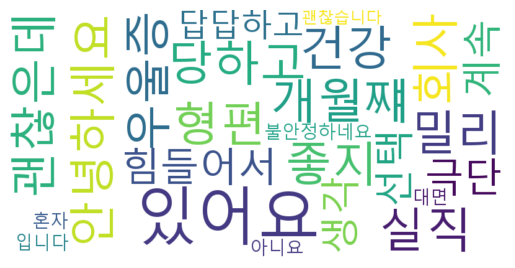

[('형편', 1), ('좋지', 1), ('개월쨰', 1), ('밀리', 1), ('건강', 1), ('괜찮은데', 1), ('우울증', 1), ('힘들어서', 1), ('극단', 1), ('선택', 1), ('계속', 1), ('생각', 1), ('답답하고', 1), ('불안정하네요', 1), ('아니요', 1), ('혼자', 1), ('입니다', 1), ('대면', 1), ('괜찮습니다', 1), ('있어요', 2)]


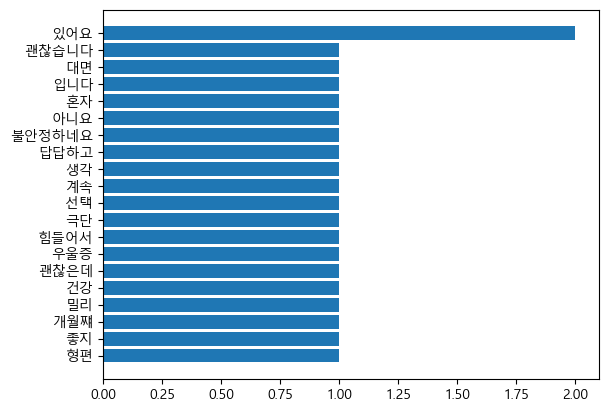

C:\Users\taekyung\AppData\Local\Temp\ipykernel_25704\893798089.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y = 'Count', data=data, palette='rocket')


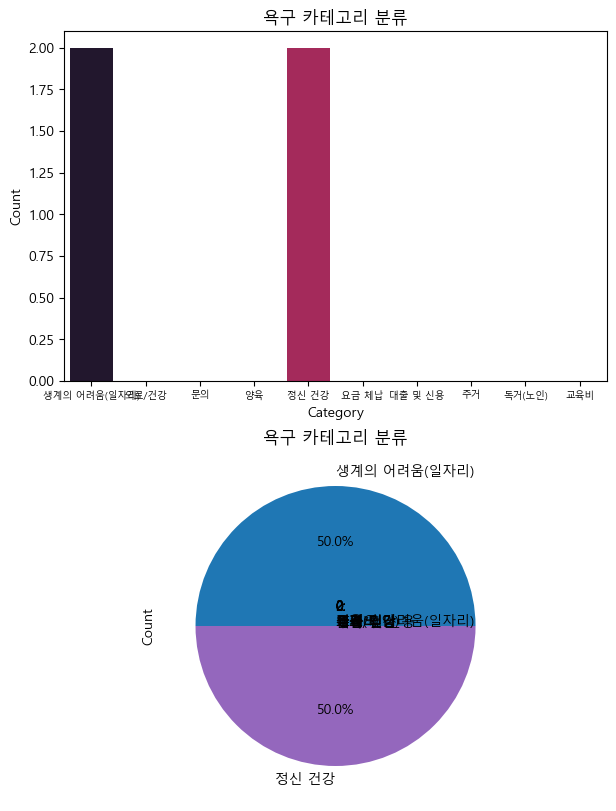

In [30]:
history = []  # 대화 기록 초기화
first_ment = f'네 안녕하세요. 맞춤형 복지 음성 서비스 아이 입니다. 통화에 앞서 본 통화는 녹취된다는 사실 말씀드립니다'
tts_module([first_ment])
print(first_ment)

while True:
    # 사용자 입력 받기
    # message = recognize_speech()
    message = input()
    print("User: ",message)
    

    # 종료하겠습니다를 입력하면 최종 요약 출력
    if message == "종료하겠습니다":
        print(history)
        tts_module(["네 지금까지 복지 음성 상담서비스 아이였습니다 감사합니다"])
        break

    history_langchain_format = []
    # 프롬프트 추가
    history_langchain_format.append(SystemMessage(content=chat_template))
    # 이전 대화 기억
    for human, ai in history:
        history_langchain_format.append(HumanMessage(content=human))
        history_langchain_format.append(AIMessage(content=ai))
    history_langchain_format.append(HumanMessage(content=message))
    gpt_response = chat_ai(history_langchain_format)
    texts = [gpt_response.content]
    tts_module(texts)
    
    print("AI:", gpt_response.content)
    history.append((message, gpt_response.content))


data = ''''''
for i in range(0,len(history)):
    data+= history[i][0]+"\n"

const_doc = data

tokens_const = [word for word, pos in t.pos(const_doc) if pos in ('Noun','Adjective')]
tokens_const = [token for token in tokens_const if token not in ['좀','혹시','지금','이제','상담사','조금','말씀','저희','계층','사회','못','그','것','있어', '줄','수','더','구','있나','한지','돼','거','네','네네','제']]
word_graph_and_wordcloud(tokens_const, max_words=20)
categorize_desire()

def categorize_and_visualize(text_input):
    tokens_const = text_input.split()

    category_lists = [list_1, list_2, list_3, list_4, list_5, list_6, list_7, list_8, list_9, list_10]
    category_names = ["생계의 어려움(일자리)", "의료/건강", "문의", "양육", "정신 건강", "요금 체납", "대출 및 신용", "주거", "독거(노인)", "교육비"]

    counts = [sum(1 for token in tokens_const if token in category_list) for category_list in category_lists]

    # Generate visualizations and save them as images
    word_graph_and_wordcloud(tokens_const, max_words=5)
    plt.savefig("word_graph_wordcloud.png")
    plt.clf()  # Clear the current figure

    visualize_weighted_count(counts, category_names)
    plt.savefig("visualize_weighted_count.png")
    plt.clf()  # Clear the current figure

    # Return paths to the saved images
    return ["word_graph_wordcloud.png", "visualize_weighted_count.png"]



In [26]:
history

[('네 안녕하세요',
  '안녕하세요, 김태경 님. 보건복지부 자료에 따르면 건강보험료 연체 상황이 있으신 것으로 나타났습니다. 혹시 그 부분에 대해 맞는 정보인지 확인해주실 수 있으신가요?'),
 ('아 네 맞아요', '연체가 발생한 건강보험료에 대해 구체적으로 어떤 문제가 있으신지 말씀해주실 수 있으신가요?'),
 ('네 회사에서 실직 당하고 형편이 좋지 않아 4개월쨰 밀리고 있어요',
  '알겠습니다. 현재 건강보험료를 납부하지 못하는 상황이시군요. 혹시 그 외에 다른 어려움이나 문제가 더 있으신가요?'),
 ('건강은 괜찮은데 우울증이 있어요. 버티기 힘들어서 극단적 선택도 계속 생각하고 답답하고 불안정하네요',
  '말씀하신 우울증과 관련된 어려움도 크시겠습니다. 현재 주변에 도움을 요청하실 수 있는 가족이나 친구, 보호자 분이 계신가요?'),
 ('아니요 혼자 입니다',
  '혼자 계시는 상황이시군요. 건강보험료 연체 문제와 우울증 관련하여 지원받으실 수 있는 복지 서비스가 있습니다. 국민건강보험공단의 지원 프로그램과 정신건강복지센터의 상담 서비스를 추천드립니다. 추가로 상담이 필요하신가요?'),
 ('네 상담 받고싶어요.', '상담을 원하시는군요. 대면 상담과 비대면 상담 중 어떤 방식을 선호하시나요?'),
 ('대면이요',
  '대면 상담을 선호하신다면, 가까운 국민건강보험공단 지사나 정신건강복지센터에 방문하셔서 상담을 받으실 수 있습니다. 방문 전에 예약을 하시는 것이 좋습니다. 도움이 필요하시면 언제든지 연락 주세요. 건강하고 안전한 하루 되시길 바랍니다. 감사합니다.')]